In [63]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2

try:
    # Font로 자동으로 이미지 만들기
    import cairocffi as cairo
except:
    !pip install cairocffi
    
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from scipy import ndimage

import re

### 한글 Matplotlib 출력 세팅

In [64]:
# 1. 나눔 폰트를 다운받기
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
# 2. 나눔 폰트의 위치 가져오기 
system_font = fm.findSystemFonts() # 현재 시스템에 설치된 폰트
nanum_fonts = [font for font in system_font if "NanumBarunGothic.ttf" in font]
font_path = nanum_fonts[0] # 설정할 폰트의 경로

# 3. 나눔 폰트로 설정하기
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc("font",family=font_name)

# 4. 폰트 재설정하기
fm._rebuild()

# 5. (optional) minus 기호 깨짐 방지
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

/bin/sh: apt-get: command not found
/bin/sh: apt-get: command not found


### 한글 단어 데이터 셋 가져오기

In [110]:
# reference : https://github.com/acidsound/korean_wordlist
df = pd.read_csv("./korean_word.csv")
words = df.kor.values

### OCR 데이터셋 구축하기

In [181]:
surface = cairo.ImageSurface(cairo.FORMAT_RGB24, 100,100)
with cairo.Context(surface) as context:
    context

In [ ]:
context.()

In [237]:
FONT_LIST = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
FONT_LIST = list(set([f for f in FONT_LIST if "Nanum" in f]))

MAX_WORD = 8 # 최대 철자 수
FONT_SIZE = 30 # 폰트 크기
MAX_HEIGHT = FONT_SIZE + 8 # 이미지의 최대 Height
MAX_WIDTH  = FONT_SIZE*MAX_WORD + 8 # 이미지 최대 Width

class OCRDataset:
    """
    generate OCR dataset for Text Recognition
    
    텍스트 Recognition에 필요한 단어집합을 만ㄷ르어주는 것
    
    :param words : OCR 단어로 생성할 단어 집합들
    :param bg_noise : 가우시안 노이즈의 강도 (0.0~0.5)
    :param angle_noise : 회전 각 노이즈의 강도
    """
    def __init__(self, words, font_size, bg_noise=0.0, angle_noise=0):
        self.words = np.array(words)
        self.max_word = max([len(word) for word in self.words])
        self.font_size = font_size
        self.bg_noise = np.clip(bg_noise,0.,0.5)
        self.angle_noise = angle_noise
        self.paint_text = lambda word : paint_text(word, 
                                                   self.max_word,
                                                   self.font_size)
        
    def __len__(self):
        # 전체 데이터 셋
        return len(self.words)
    
    def __getitem__(self, index):
        """
        (1) index -> integer일 때, get single item
        (2) index -> np.array | slice, get batch items
        """
        #
        if isinstance(index, int):
            word = self.words[index]
            image = self.paint_text(word)
            if self.bg_noise > 0:
                image = gaussian_noise(image, self.bg_noise)
            if self.angle_noise >0:
                image = random_rotate(image, self.angle_noise)
            return image, word
        else:
            words = self.words[index]
            images = []
            for word in words:
                image = self.paint_text(word)
                if self.bg_noise > 0:
                    image = gaussian_noise(image, self.bg_noise)
                if self.angle_noise >0:
                    image = random_rotate(image, self.angle_noise)                
                images.append(image)
            return np.stack(images), words

    def shuffle(self):
        np.random.shuffle(self.words)
        
def paint_text(text, max_word=None, font_size=FONT_SIZE):
    '''
    Text가 그려진 이미지를 만드는 함수
    
    max
    '''
    if max_word is None:
        # None이면, text의 word 갯수에 맞춰서 생성
        max_word = len(text)
    h = font_size + 8 # 이미지 높이, font_size + padding
    w = font_size * max_word + 8 # 이미지 폭    
    
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)
    with cairo.Context(surface) as context:
        context.set_source_rgb(1, 1, 1)  # White
        context.paint()
        
        # Font Style : Random Pick
        context.select_font_face(
            np.random.choice(FONT_LIST),
            cairo.FONT_SLANT_NORMAL,
            np.random.choice([cairo.FONT_WEIGHT_BOLD,
                              cairo.FONT_WEIGHT_NORMAL]))
        
        context.set_font_size(font_size)
        box = context.text_extents(text)          
        border_w_h = (4, 4)
        if box[2] > (w - 2 * border_w_h[1]) or box[3] > (h - 2 * border_w_h[0]):
            raise IOError(('Could not fit string into image.'
                           'Max char count is too large for given image width.'))

        # Random Shift을 통해, 이미지 Augmentation
        max_shift_x = w - box[2] - border_w_h[0]
        max_shift_y = h - box[3] - border_w_h[1]
        top_left_x = np.random.randint(0, int(max_shift_x))
        top_left_y = np.random.randint(0, int(max_shift_y))
        
        context.move_to(top_left_x - int(box[0]),
                        top_left_y - int(box[1]))
        
        # Draw Text
        rgb = np.random.uniform(0.5,0.9,size=3)
        
        context.set_source_rgb(*rgb)
        context.show_text(text)
    
    # cairo data format to numpy data format
    buf = surface.get_data()
    text_image = np.frombuffer(buf, np.uint8)
    text_image = text_image.reshape(h,w,4)
    text_image = text_image[:,:,:3]
    text_image = text_image.astype(np.float32) / 255
    
    return text_image

def gaussian_noise(image,noise=0.1):
    '''
    이미지에 가우시안 잡음을 넣어주는 함수
    Data Augmentation을 적용하기 위함    
    '''
    image = image + np.random.normal(0, noise, size=image.shape)
    return np.clip(image,0,1)

def random_rotate(image, max_angle=30):
    h,w = image.shape[:2]
    angle = np.random.randint(-max_angle,max_angle)
    M = cv2.getRotationMatrix2D((w//2,h//2),angle,1.)
    return cv2.warpAffine(image, M, (w, h))

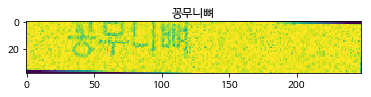

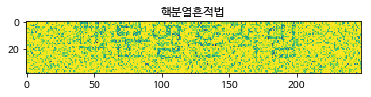

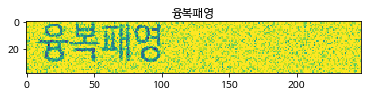

In [249]:
dataset = OCRDataset(words, 30, 0.1, 3)
dataset.shuffle()
images, labels  = dataset[0:3]
for image, label in zip(images, labels):
    plt.title(label)
    plt.imshow(image[:,:,0])
    plt.show()

## Generator 구현하기

In [221]:
가 = ord('가')
힣 = ord('힣')

KOR_CHARS = [chr(idx) for idx in range(가,힣+1)]
KOR2IDX = { char : idx for idx, char in enumerate(kor_chars)}

In [223]:
class OCRGenerator(Sequence):
    "Generates OCR TEXT Recognition Dataset for Keras"

    def __init__(self, dataset, char_list=KOR_CHARS, batch_size=32, shuffle=True):
        """
        Initialization
        
        param 
        :param dataset : instance of class 'OCRDataset'
        :param char_list : unique character list (for Embedding)
        :param batch_size : the number of batch
        :param shuffle : whether shuffle dataset or not
        """
        self.dataset = dataset
        self.char_list = char_list
        self.char2idx = { char : idx 
                         for idx, char 
                         in enumerate(self.char_list)}
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_classes = len(self.char_list) + 1  # With Blank for CTC LOSS
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return len(self.dataset) // self.batch_size

    def __getitem__(self, index):
        "Generator one batch of dataset"
        images, texts, _ = self.dataset[self.batch_size * index:
                                        self.batch_size * (index + 1)]
        # label sequence
        labels = np.ones([self.batch_size, self.max_length], np.int32)
        label_length = np.zeros([self.batch_size, 1], np.int32)
        labels *= -1  # EOS Token value : -1
        for idx, text in enumerate(texts):
            labels[idx, :len(text)] = text2label(text,self.char2idx)
            label_length[idx] = len(text)

        return images, labels, label_length

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        if self.shuffle:
            self.dataset.shuffle()
            

def text2label(text, char2idx=KOR2IDX):
    return np.array([char2idx[char] for char in text])